## Under the Hood: Training a Digit Classifier:

We will be trying to understand how a deep learning model works underneath, we will be using the MNIST number classification dataset for this.

In [1]:
from fastai.vision.all import *
import pandas as pd


For this initial tutorial we are just going to try to create a model that can classify any image as a 3 or a 7. So let's download a sample of MNIST that contains images of just these digits:

In [2]:
path = untar_data(URLs.MNIST_SAMPLE)

In [3]:
Path.BASE_PATH = path

In [4]:
path.ls()

(#3) [Path('labels.csv'),Path('train'),Path('valid')]

In [5]:
(path/'train').ls()

(#2) [Path('train/3'),Path('train/7')]

In [6]:
threes = (path/'train'/'3').ls().sorted()
sevens = (path/'train'/'7').ls().sorted()
threes

(#6131) [Path('train/3/10.png'),Path('train/3/10000.png'),Path('train/3/10011.png'),Path('train/3/10031.png'),Path('train/3/10034.png'),Path('train/3/10042.png'),Path('train/3/10052.png'),Path('train/3/1007.png'),Path('train/3/10074.png'),Path('train/3/10091.png'),Path('train/3/10093.png'),Path('train/3/10097.png'),Path('train/3/10099.png'),Path('train/3/10116.png'),Path('train/3/10125.png'),Path('train/3/10137.png'),Path('train/3/10141.png'),Path('train/3/10144.png'),Path('train/3/10155.png'),Path('train/3/10161.png')...]

In [7]:
im3_path = threes[1]
im3 = Image.open(im3_path)
im3

In [8]:
array(im3)[4:10, 4:10]

array([[  0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,  29],
       [  0,   0,   0,  48, 166, 224],
       [  0,  93, 244, 249, 253, 187],
       [  0, 107, 253, 253, 230,  48],
       [  0,   3,  20,  20,  15,   0]], dtype=uint8)

In [9]:
tensor(im3)[4:10, 4:10]

tensor([[  0,   0,   0,   0,   0,   0],
        [  0,   0,   0,   0,   0,  29],
        [  0,   0,   0,  48, 166, 224],
        [  0,  93, 244, 249, 253, 187],
        [  0, 107, 253, 253, 230,  48],
        [  0,   3,  20,  20,  15,   0]], dtype=torch.uint8)

Let's show it in display with colouring the pixel using pandas dataframe.

In [10]:
im3_t = tensor(im3)
df = pd.DataFrame(im3_t[0:20, 4:25])
df.style.set_properties(**{'font-size':'6pt'}).background_gradient('Greys')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,29,150,195,254,255,254,176,193,150,96,0,0,0,0,0,0
6,0,0,0,48,166,224,253,253,234,196,253,253,253,253,233,0,0,0,0,0,0
7,0,93,244,249,253,187,46,10,8,4,10,194,253,253,233,0,0,0,0,0,0
8,0,107,253,253,230,48,0,0,0,0,0,192,253,253,156,0,0,0,0,0,0
9,0,3,20,20,15,0,0,0,0,0,43,224,253,245,74,0,0,0,0,0,0


Before we read more:

Let's analyze how a computer would understand the patterns.

## **From what i know the model goes through batch of pixels and then finds the most impactful feature in that batch, using kernel size.**

Book method: For baseline let's try and find the average value for each pixel for 3's and 7's. This gives us two averages, then we classify one it as one digit or the other. 

In [11]:
seven_tensors = [tensor(Image.open(o)) for o in sevens]

In [12]:
three_tensors = [tensor(Image.open(o)) for o in threes]

In [13]:
len(three_tensors),len(seven_tensors)

(6131, 6265)

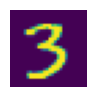

In [14]:
show_image(three_tensors[1]);

In [15]:
# Create a rank three stacked tensor
stacked_seven = torch.stack(seven_tensors).float()/255
stacked_threes = torch.stack(three_tensors).float()/255
stacked_threes.shape

torch.Size([6131, 28, 28])

In [16]:
# This is the rank of the tensor
len(stacked_seven.shape)

3

In [17]:
## Find mean of three's and seven's stacked
mean3 = stacked_threes.mean(0)
mean7 = stacked_seven.mean(0)

<Axes: >

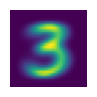

In [18]:
show_image(mean3)

<Axes: >

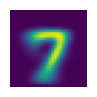

In [19]:
show_image(mean7)

In [20]:
a_3 = stacked_threes[1]
a_7 = stacked_seven[2]

In [21]:
# Calculate MAE and MSE for 3 and 7
dist_3_abs = (a_3 - mean3).abs().mean()
dist_3_sqr = ((a_3 - mean3) ** 2).mean().sqrt()
dist_3_abs, dist_3_sqr

(tensor(0.1114), tensor(0.2021))

In [22]:
dist_7_abs = (a_3 - mean7).abs().mean()
dist_7_sqr = ((a_3 - mean7)**2).mean().sqrt()
dist_7_abs,dist_7_sqr

(tensor(0.1586), tensor(0.3021))

In [23]:
valid_3_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'3').ls()])
valid_7_tens = torch.stack([tensor(Image.open(o)) for o in (path/'valid'/'7').ls()])

In [24]:
valid_3_tens = valid_3_tens.float()/255
valid_7_tens = valid_7_tens.float()/255
valid_3_tens.shape,valid_7_tens.shape


(torch.Size([1010, 28, 28]), torch.Size([1028, 28, 28]))

In [25]:
def mnist_distance(a,b):
    return (a-b).abs().mean((-1, -2))

In [26]:
mnist_distance(a_3, mean3)

tensor(0.1114)

In [27]:
valid_3_dist = mnist_distance(valid_3_tens, mean3)

In [28]:
valid_3_dist, valid_3_dist.shape


(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

In [29]:
valid_3_tens.shape

torch.Size([1010, 28, 28])

In [30]:
## Function to calcualte accuracy

def is_3(x):
    return mnist_distance(x, mean3) < mnist_distance(x, mean7)

In [31]:
is_3(a_3), is_3(a_3).float()

(tensor(True), tensor(1.))

In [32]:
is_3(valid_3_tens)


tensor([ True,  True,  True,  ..., False,  True,  True])

In [33]:
accuracy_3 = is_3(valid_3_tens).float().mean()
accuracy_7 = (1 - is_3(valid_7_tens).float().mean())

In [34]:
accuracy_3,accuracy_7,(accuracy_3+accuracy_7)/2

(tensor(0.9168), tensor(0.9854), tensor(0.9511))

## BEST APPROACH : USE WEIGHTS

In [35]:

def f(x): return x**2

def plot_function(func, x_range, label):
    x = np.linspace(*x_range, 100)
    y = func(x)
    plt.plot(x, y, label=label)
    plt.xlabel('x')
    plt.ylabel('f(x)')
    plt.title(f'Plot of {label}')
    plt.grid(True)
    plt.legend()



In [36]:
xt = tensor(3.).requires_grad_()

In [37]:
yt = f(xt)

In [38]:
yt

tensor(9., grad_fn=<PowBackward0>)

In [39]:
yt.backward()

In [40]:
xt.grad

tensor(6.)

## End to end SGD example

In [41]:
time = torch.arange(0,20).float(); time

tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12., 13.,
        14., 15., 16., 17., 18., 19.])

In [42]:
speed = torch.randn(20)*3 + 0.75*(time-9.5)**2 + 1

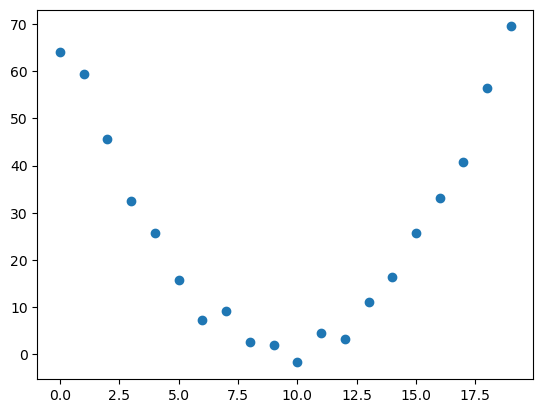

In [43]:
plt.scatter(time,speed);

In [44]:
def f(t, params):
    a,b,c = params
    return a*(t**2) + (b*t) + c
     

In [45]:
## USe mean sqaured error as loss function
def mse(preds, targets):
    return ((preds - targets) ** 2).mean()

In [46]:
# Step 1: Initialize paramter weights
params = torch.randn(3).requires_grad_()

In [47]:
orig_params = params.clone()

In [48]:
# Step 2: Calculate the preds
preds = f(time, params)

In [49]:
def show_preds(preds, ax = None):
    if ax is None: ax = plt.subplots()[1]
    ax.scatter(time,speed)
    ax.scatter(time, to_np(preds), color = 'r')
    ax.set_ylim(-300, 100)

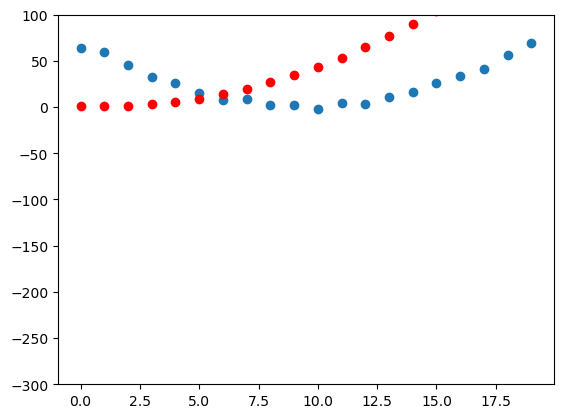

In [50]:
show_preds(preds)

In [51]:
# Step 3: Calculate loss
loss = mse(preds, speed)
loss

tensor(3658.6809, grad_fn=<MeanBackward0>)

In [52]:
# Step 4: Calculate the gradients
loss.backward()
params.grad

tensor([18480.6484,  1175.4429,    60.8065])

In [53]:
params.grad * 1e-5

tensor([0.1848, 0.0118, 0.0006])

In [54]:
params

tensor([ 0.5303, -1.0908,  1.4350], requires_grad=True)

In [55]:
# Step the weights
lr = 1e-5
params.data -=lr * params.grad.data
params.grad = None

In [56]:

preds = f(time,params)
mse(preds, speed)

tensor(1198.2195, grad_fn=<MeanBackward0>)

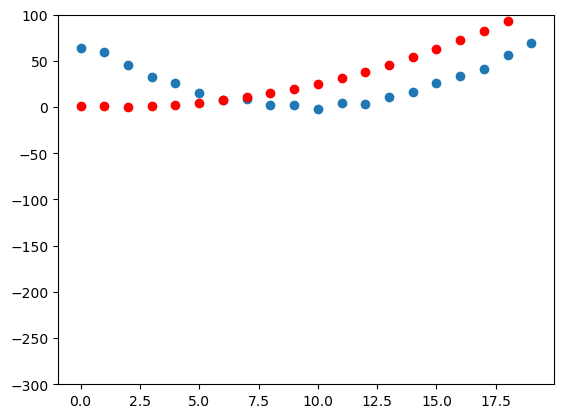

In [57]:
show_preds(preds)


In [58]:
def apply_step(params, prn=True):
    preds = f(time, params)
    loss = mse(preds, speed)
    loss.backward()
    params.data -= lr * params.grad.data
    params.grad = None
    if prn: print(loss.item())
    return preds
     

In [59]:
# Iterate 10 times
for i in range(10): apply_step(params)


1198.219482421875
732.6204833984375
644.5106201171875
627.8333129882812
624.6731567382812
624.0709228515625
623.95263671875
623.9261474609375
623.9166259765625
623.9107666015625


In [60]:
params = orig_params.detach().requires_grad_()


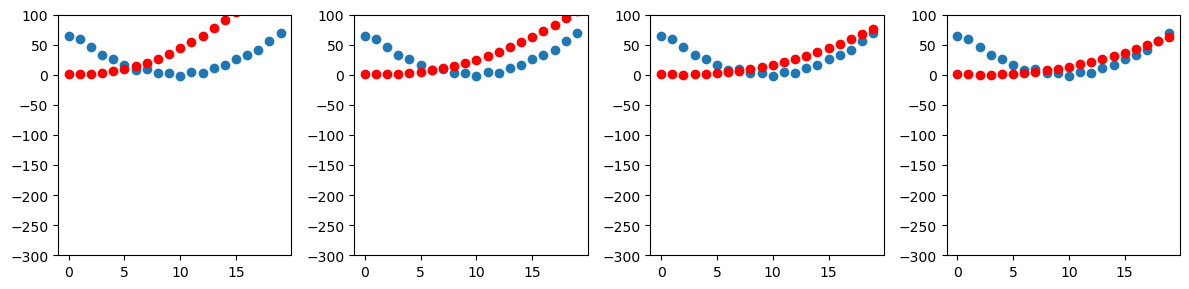

In [61]:
_,axs = plt.subplots(1,4,figsize=(12,3))
for ax in axs: show_preds(apply_step(params, False), ax)
plt.tight_layout()

## MNIST LOSS FUNCTION:

In [62]:
# Combine stacked_threes and stacked_sevens together
train_x = torch.cat([stacked_threes, stacked_seven]).view(-1, 28* 28)


In [63]:
train_x.shape

torch.Size([12396, 784])

In [64]:
train_y = tensor(([1] * len(threes) )+ ([0] * len(sevens))).unsqueeze(1)

In [65]:
# Create dataset
dset = list(zip(train_x, train_y))

In [66]:
x, y = dset[0]
x.shape,y


(torch.Size([784]), tensor([1]))

In [67]:
# Do same for validation set
valid_x = torch.cat([valid_3_tens, valid_7_tens]).view(-1, 28*28)

In [68]:
valid_x.shape

torch.Size([2038, 784])

In [69]:
valid_y = tensor([1] * len(valid_3_tens) + [0] * len(valid_7_tens)).unsqueeze(1)

In [70]:
valid_dset = list(zip(valid_x, valid_y))

In [71]:
# Initializing random weights
def init_params(size, std = 1.0):
    return (torch.randn(size) * std).requires_grad_()

In [72]:
weights = init_params((28*28, 1))  # shape: [28, 28, 1]


In [73]:
# Initialize bias
bias = init_params(1)

In [74]:
# (train_x[1] * weights.T).sum() + bias

In [75]:
# Instead of using loops we can use matrix multiplication for faster results
def linear(xb):
    return xb@weights + bias

In [76]:
preds = linear(train_x)

In [77]:
preds

tensor([[ 8.1811],
        [12.6793],
        [-1.6994],
        ...,
        [ 4.5169],
        [ 4.7493],
        [13.8402]], grad_fn=<AddBackward0>)

In [78]:
corrects = (preds > 0.0).float() == train_y

In [79]:
corrects

tensor([[ True],
        [ True],
        [False],
        ...,
        [False],
        [False],
        [False]])

In [80]:
corrects.float().mean().item()

0.5962406992912292

In [81]:
with torch.no_grad(): weights[0] *= 1.00001

In [82]:
preds = linear(train_x)
((preds>0.0).float() == train_y).float().mean().item()

0.5962406992912292

In [83]:
# Lets say we know Index 0 and two are images of three
targets = tensor([1,0,1])

In [84]:
# And our models predictions are
prds = tensor([0.9, 0.4, 0.2])

In [85]:
def mnist_loss(predictions, targets):
    return torch.where(targets == 1, 1-predictions, predictions).mean()

In [86]:
torch.where(targets == 1, 1-prds, prds)

tensor([0.1000, 0.4000, 0.8000])

In [87]:
mnist_loss(torch.where(targets == 1, 1-prds, prds) ,targets)

tensor(0.5000)

In [88]:
mnist_loss(tensor([0.9, 0.4, 0.8]), targets)

tensor(0.2333)

To fix this issue where we need 0 or 1 i.e true or false we use sigmoid function

In [89]:
def mnist_loss(predictions, targets):
    predictions = predictions.sigmoid()
    return torch.where(targets == 1, 1-predictions, predictions).mean()

## SGD and Mini Batches

In [90]:
weights = init_params((28*28, 1))
bias = init_params(1)

In [91]:
dl = DataLoader(dset, batch_size = 256)
xb, yb = first(dl)
xb.shape, yb.shape

(torch.Size([256, 784]), torch.Size([256, 1]))

In [92]:
valid_dl = DataLoader(valid_dset, batch_size = 256)

In [93]:
batch = train_x[:4]
batch.shape

torch.Size([4, 784])

In [94]:
preds = linear(batch)
preds

tensor([[-28.5700],
        [-29.3861],
        [-17.3057],
        [-31.5858]], grad_fn=<AddBackward0>)

In [95]:
loss = mnist_loss(preds, train_y[:4])
loss

tensor(1., grad_fn=<MeanBackward0>)

In [96]:
loss.backward()
weights.grad.shape, weights.grad.mean(), bias.grad

(torch.Size([784, 1]), tensor(-1.0936e-09), tensor([-7.6240e-09]))

In [97]:
def calc_grad(xb, yb, model):
    preds = model(xb)
    loss = mnist_loss(preds, yb)
    loss.backward()

In [98]:
calc_grad(batch, train_y[:4], linear)
weights.grad.mean(), bias.grad

(tensor(-2.1871e-09), tensor([-1.5248e-08]))

In [99]:
def train_epoch(model, lr,params):
    for xb, yb in dl:
        calc_grad(xb, yb,model)
        for p in params:
            p.data -= p.grad * lr
            p.grad.zero_()


In [100]:
(preds > 0.0).float() == train_y[:4]

tensor([[False],
        [False],
        [False],
        [False]])

In [101]:
def batch_accuracy(xb, yb):
    preds = xb.sigmoid()
    correct = (preds > 0.5) == yb
    return correct.float().mean()

In [102]:
batch_accuracy(linear(batch), train_y[:4])

tensor(0.)

In [103]:
def validate_epoch(model):
    accs = [batch_accuracy(model(xb), yb) for xb, yb in valid_dl]
    return round(torch.stack(accs).mean().item(), 4)

In [104]:
validate_epoch(linear)

0.5043

In [105]:
lr = 1.
params = weights, bias
train_epoch(linear, lr, params)
validate_epoch(linear)

0.5068

In [106]:
for i in range(20):
    train_epoch(linear, lr, params)
    print(validate_epoch(linear), end = ' ')

0.5068 0.5068 0.5068 0.5068 0.5068 0.5063 0.5063 0.5068 0.5073 0.5078 0.5093 0.6928 0.8847 0.9336 0.9477 0.958 0.9633 0.9653 0.9668 0.9677 

## Creating optimizer

In [107]:
linear_model = nn.Linear(28*28, 1)

In [108]:
w,b = linear_model.parameters()
w.shape, b.shape

(torch.Size([1, 784]), torch.Size([1]))

## Optimizer class:

In [109]:
class BasicOptim:
    def __init__(self, params, lr): self.params, self.lr = list(params), lr
    def step(self, *args, **kwargs):
        for p in self.params: p.data -= p.grad.data *self.lr

    def zero_grad(self, *args, **kwargs):
        for p in self.params: p.grad = None

In [110]:
opt = BasicOptim(linear_model.parameters(), lr)

In [111]:
def train_epoch(model):
    for xb, yb in dl:
        calc_grad(xb, yb, model)
        opt.step()
        opt.zero_grad()

In [112]:
validate_epoch(linear_model)

0.4273

In [113]:
def train_model(model, epochs):
    for i in range(epochs):
        train_epoch(model)
        print(validate_epoch(model), end = ' ')

In [114]:
train_model(linear_model, 20)

0.4932 0.7896 0.8496 0.915 0.9351 0.9487 0.9565 0.9634 0.9658 0.9673 0.9707 0.9726 0.9741 0.9751 0.9761 0.9765 0.9775 0.978 0.9785 0.979 

In [115]:
linear_model = nn.Linear(28*28, 1)
opt = SGD(linear_model.parameters(), lr)
train_model(linear_model, 20)

0.4932 0.9062 0.7998 0.9058 0.9312 0.9448 0.9551 0.9624 0.9648 0.9673 0.9687 0.9712 0.9736 0.9746 0.9761 0.9765 0.9775 0.978 0.9785 0.979 

In [116]:
dls = DataLoaders(dl, valid_dl)

In [117]:
learn = Learner(dls, nn.Linear(28*28, 1), opt_func = SGD, loss_func = mnist_loss, metrics = batch_accuracy)

In [118]:
learn.fit(10, lr)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.636917,0.503602,0.495584,00:00
1,0.564468,0.153388,0.888616,00:00
2,0.205451,0.205372,0.807164,00:00
3,0.089273,0.113022,0.907753,00:00
4,0.046474,0.080689,0.931305,00:00
5,0.029801,0.064017,0.944063,00:00
6,0.022986,0.053786,0.954367,00:00
7,0.019992,0.047020,0.961727,00:00
8,0.018496,0.042285,0.965162,00:00
9,0.017608,0.038809,0.966634,00:00


In [119]:
# Adding non linearity i.e RELU
def simple_net(xb):
    res = xb@w1 + b1
    res = res.max(tensor(0.0))
    res = res@w2 + b2
    return res

In [121]:
w1 = init_params((28*28,30))
b1 = init_params(30)
w2 = init_params((30,1))
b2 = init_params(1)

In [123]:
simple_net = nn.Sequential(
    nn.Linear(28 * 28, 30),
    nn.ReLU(),
    nn.Linear(30, 1)
)

In [124]:
learner = Learner(dls, simple_net, opt_func = SGD, loss_func=mnist_loss, metrics = batch_accuracy)

In [125]:
learn.fit(40, 0.1)

epoch,train_loss,valid_loss,batch_accuracy,time
0,0.026763,0.030573,0.974975,00:00
1,0.023992,0.028608,0.975466,00:00
2,0.022632,0.028030,0.977920,00:00
3,0.021992,0.027820,0.978410,00:00
4,0.021691,0.027706,0.978410,00:00
5,0.021532,0.027612,0.977429,00:00
6,0.021425,0.027520,0.977429,00:00
7,0.021333,0.027424,0.977429,00:00
8,0.021244,0.027327,0.977429,00:00
9,0.021155,0.027230,0.977429,00:00


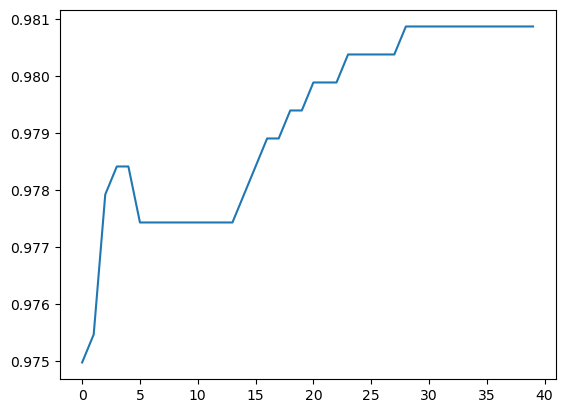

In [126]:
plt.plot(L(learn.recorder.values).itemgot(2));

In [127]:
# Accuracy
learn.recorder.values[-1][2]

0.9808635711669922